In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# change parent dir to the "projects" folder (../8_diffusion)
import sys
sys.path.append('../..')  # Adds the parent directory to the Python path

plt.style.use("seaborn-v0_8-colorblind")

import math

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)
from keras.utils import register_keras_serializable

from utils import display, sample_batch

In [2]:
# Parameters
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = True

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 1

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "../../data/pytorch-challange-flower-dataset/dataset",
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 8189 files.


In [4]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

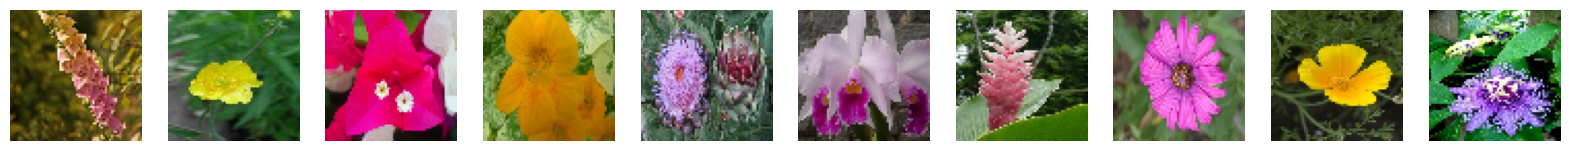

In [5]:
# Show some items of clothing from the training set
train_sample = sample_batch(train)
display(train_sample)

### 1.1 Diffusion schedules <a name="diffusion_schedules"></a>

In [6]:
# Q: define these diffusion schedule's purpose
# A: 
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

In [7]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

In [8]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [9]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
    diffusion_times
)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
    diffusion_times
)
(
    offset_cosine_noise_rates,
    offset_cosine_signal_rates,
) = offset_cosine_diffusion_schedule(diffusion_times)

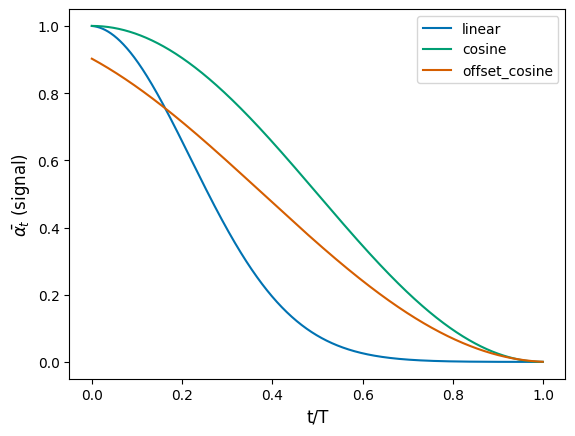

In [10]:
plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

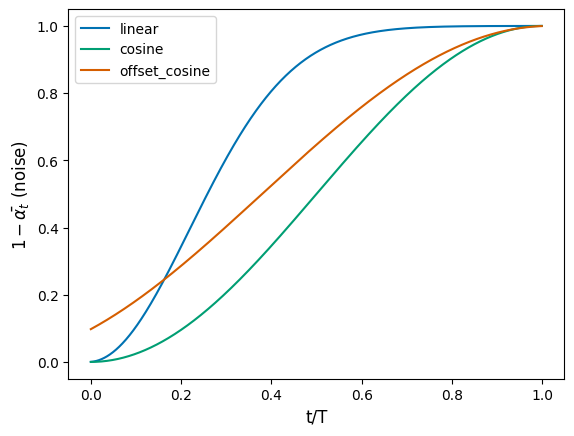

In [11]:
plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()

## 2. Build the model <a name="build"></a>

In [12]:
# Q: define the purpose of using a sinusoidal embedding vs other embedding variations in diffusion
# A: 

@register_keras_serializable()
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

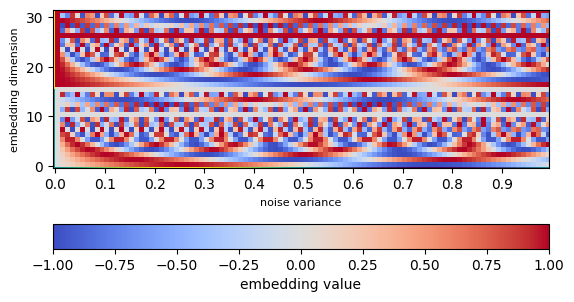

In [13]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [14]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [15]:
# Build the U-Net

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [16]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [17]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

2024-08-05 23:16:57.637112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
if LOAD_MODEL:
    ddm.built = True
    ddm.load_weights("./checkpoint/checkpoints.weights.h5")
    print("Loaded model")

Loaded model


## 3.Train the model <a name="train"></a>

In [19]:
ddm.compile(
    optimizer=optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.MeanAbsoluteError(),
)

639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - n_loss: 0.1729
Saved to ./output/generated_img_000.png


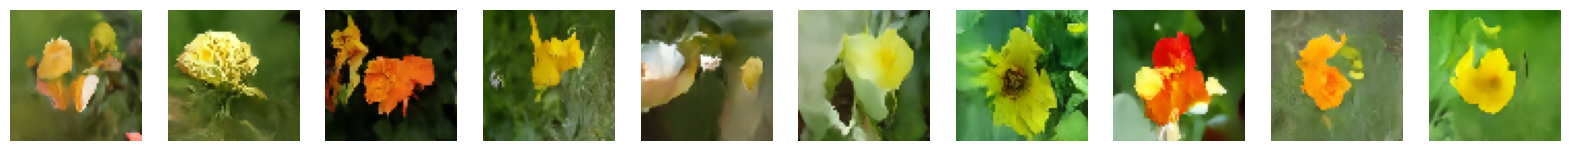

639/639 ━━━━━━━━━━━━━━━━━━━━ 1109s 2s/step - n_loss: 0.1729


In [20]:
# run training and plot generated images periodically
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoints.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


image_generator_callback = ImageGenerator(num_img=10)

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

In [21]:
## 4. Inference <a name="inference"></a>

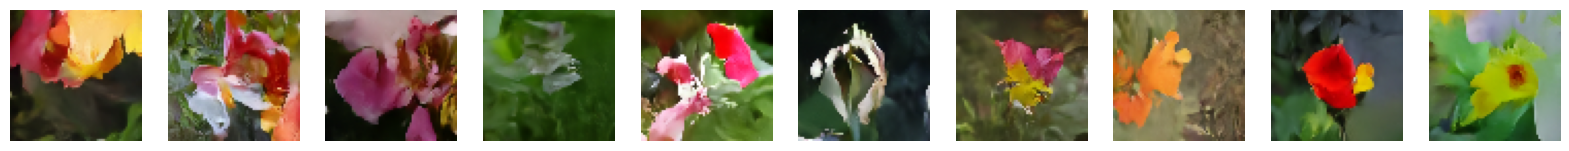

In [22]:
# Generate some novel images of flowers
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

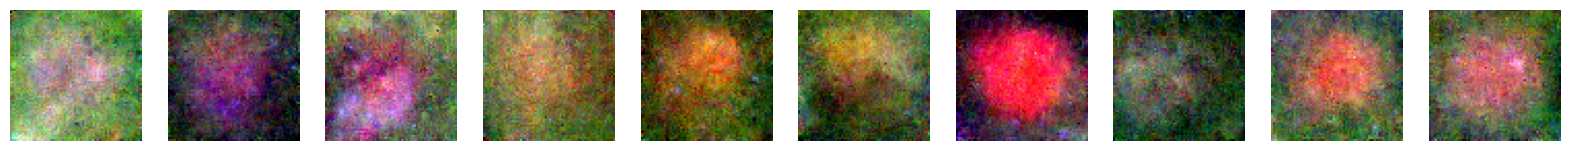

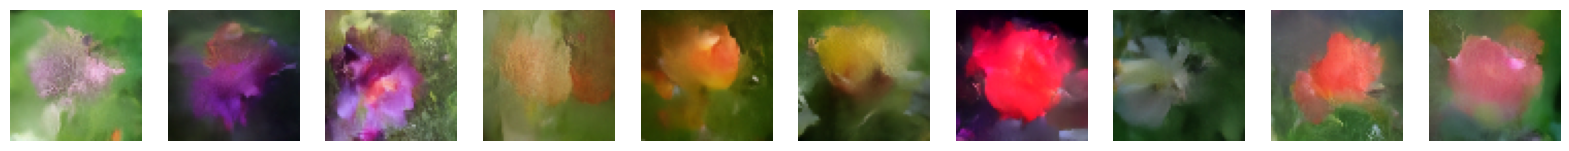

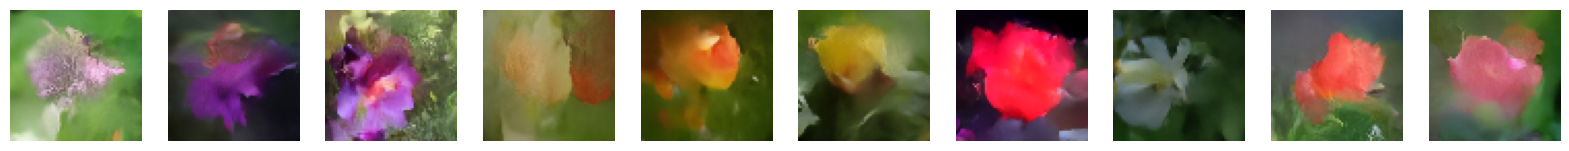

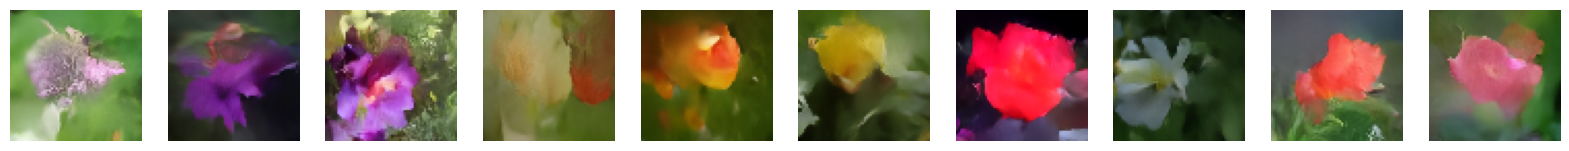

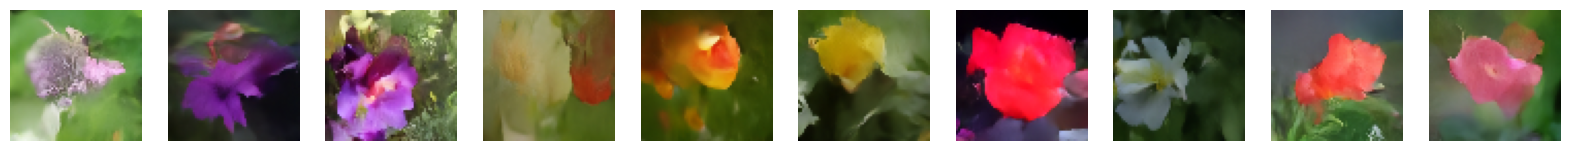

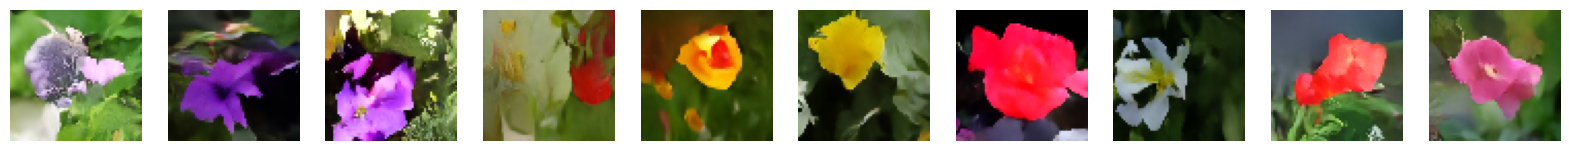

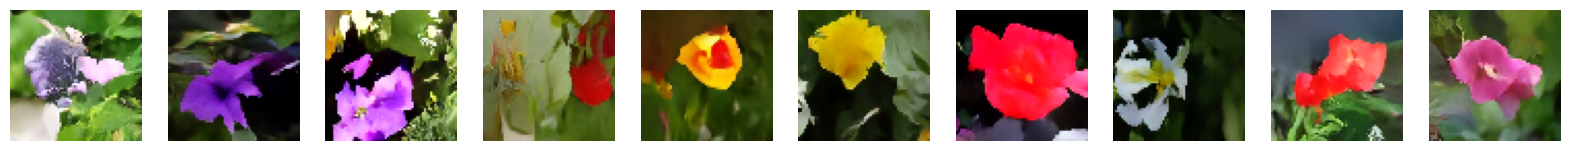

In [23]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images)

In [24]:
# Interpolation between two points in the latent space
tf.random.set_seed(100)


def spherical_interpolation(a, b, t):
    return np.sin(t * math.pi / 2) * a + np.cos(t * math.pi / 2) * b


for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    initial_noise = np.array(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    generated_images = ddm.generate(
        num_images=2, diffusion_steps=20, initial_noise=initial_noise
    ).numpy()
    display(generated_images, n=11)

ValueError: In a nested call() argument, you cannot mix tensors and non-tensors. Received invalid mixed argument: inputs=[array([[[[ 6.49735868e-01,  3.27914953e-01, -7.51981497e-01],
         [-2.14300960e-01,  5.25993168e-01,  1.19929039e+00],
         [-1.29207397e+00,  1.15016304e-01, -4.26958591e-01],
         ...,
         [ 7.03131378e-01, -7.33605206e-01, -3.70452464e-01],
         [ 6.48666859e-01,  2.18931985e+00, -1.33762097e+00],
         [-9.31460798e-01,  1.41777837e+00, -1.88928992e-01]],

        [[ 1.31689698e-01, -6.77145064e-01,  7.40400910e-01],
         [ 8.59436035e-01, -2.87093759e-01, -8.64649862e-02],
         [ 2.84599870e-01, -2.11268210e+00,  1.14838731e+00],
         ...,
         [-6.77489489e-02, -8.61240506e-01, -5.44723094e-01],
         [ 2.71109372e-01,  1.01086304e-01, -4.73207772e-01],
         [-5.60641706e-01, -1.13400590e+00,  8.42345893e-01]],

        [[-3.80306877e-02, -2.49217153e+00, -6.89853251e-01],
         [-2.30352497e+00,  4.27725554e-01,  8.63602310e-02],
         [ 3.43603119e-02,  6.13083005e-01,  1.31838250e+00],
         ...,
         [ 6.87917411e-01,  7.17745304e-01, -1.83920473e-01],
         [ 9.56035495e-01,  1.45205033e+00,  3.71186316e-01],
         [ 6.08661287e-02,  1.86150953e-01,  8.81386518e-01]],

        ...,

        [[-1.04554939e+00,  1.00320995e+00, -8.11423600e-01],
         [ 1.98202968e-01, -2.84702808e-01,  4.75608289e-01],
         [-5.35816371e-01,  2.25844219e-01, -4.47696388e-01],
         ...,
         [ 2.67654002e-01,  9.32196021e-01,  7.30675340e-01],
         [ 1.01251328e+00,  4.52767432e-01, -1.61081046e-01],
         [ 2.52104521e-01, -4.64738876e-01,  7.48203695e-01]],

        [[ 9.98408139e-01, -9.98852432e-01,  5.40751100e-01],
         [-7.06940815e-02,  6.86931312e-01, -4.66775715e-01],
         [ 5.54335177e-01,  2.12634063e+00, -1.79539311e+00],
         ...,
         [-8.00098598e-01,  1.85149133e-01, -1.25963199e+00],
         [-9.41212058e-01, -6.78259432e-01,  8.82360756e-01],
         [ 2.15707757e-02,  5.16756624e-02,  1.44199693e+00]],

        [[ 5.31310380e-01,  1.76338053e+00, -2.61005819e-01],
         [-1.27880555e-03,  5.33019781e-01, -1.21937346e+00],
         [ 5.13074815e-01,  6.41567945e-01, -1.09711206e+00],
         ...,
         [ 4.01848584e-01,  2.73792148e-01,  4.82537039e-02],
         [-2.09739894e-01,  4.33572605e-02, -2.10958585e-01],
         [ 1.89432994e-01,  2.67964900e-01,  2.22220850e+00]]],


       [[[ 6.66847765e-01,  6.42327070e-02, -9.35471416e-01],
         [-1.18245244e-01,  6.85492456e-01,  9.76818144e-01],
         [-1.31982958e+00,  1.10249631e-01, -6.56705558e-01],
         ...,
         [ 5.97645283e-01, -8.66026998e-01, -4.85172331e-01],
         [ 7.55416870e-01,  2.15833879e+00, -1.46295917e+00],
         [-1.22040963e+00,  1.58049083e+00, -3.01000535e-01]],

        [[ 4.12099242e-01, -7.66398013e-01,  8.31129074e-01],
         [ 1.00679207e+00, -2.29916900e-01, -3.45778197e-01],
         [ 3.43412250e-01, -2.06788659e+00,  1.22843039e+00],
         ...,
         [-1.34612530e-01, -7.97557294e-01, -3.73196065e-01],
         [ 3.23880255e-01,  2.49116451e-01, -4.02976662e-01],
         [-4.57700044e-01, -1.17222869e+00,  6.58427119e-01]],

        [[-1.30959302e-01, -2.39909315e+00, -7.52730429e-01],
         [-2.31395483e+00,  7.02733755e-01, -3.40586007e-02],
         [ 9.88429599e-03,  6.48171961e-01,  1.47345030e+00],
         ...,
         [ 5.84687293e-01,  6.66292548e-01, -1.82030454e-01],
         [ 8.58088851e-01,  1.55997002e+00,  3.67950648e-01],
         [ 7.64818341e-02,  2.34392554e-01,  1.02481973e+00]],

        ...,

        [[-8.66764903e-01,  9.17813361e-01, -1.03481948e+00],
         [ 2.86132455e-01, -2.42071196e-01,  3.59438002e-01],
         [-6.76016927e-01,  1.73446089e-01, -4.11499113e-01],
         ...,
         [ 3.80223483e-01,  1.06160891e+00,  7.90040970e-01],
         [ 8.62802744e-01,  1.66274637e-01, -3.18743765e-01],
         [ 3.42363358e-01, -6.05990231e-01,  9.82521296e-01]],

        [[ 1.25001800e+00, -1.03871322e+00,  5.13143182e-01],
         [-2.08193630e-01,  3.68750811e-01, -4.88902152e-01],
         [ 8.51655424e-01,  2.22668839e+00, -1.62426853e+00],
         ...,
         [-7.65395522e-01,  3.82175922e-01, -1.14609230e+00],
         [-1.03035724e+00, -4.33862776e-01,  8.36462975e-01],
         [-2.49858081e-01,  1.04052030e-01,  1.25670636e+00]],

        [[ 5.28379560e-01,  1.54599190e+00, -4.42510694e-02],
         [ 1.52338848e-01,  6.65799320e-01, -1.14703262e+00],
         [ 6.58211946e-01,  6.22144341e-01, -8.14824343e-01],
         ...,
         [ 9.07476842e-02,  4.04423475e-01,  4.02951390e-02],
         [-4.92816865e-01,  2.79996116e-02, -2.19602734e-01],
         [ 9.11000371e-02,  3.05989683e-01,  2.15493178e+00]]],


       [[[ 6.67539656e-01, -2.01031178e-01, -1.09592700e+00],
         [-1.92779452e-02,  8.28112721e-01,  7.30293393e-01],
         [-1.31508648e+00,  1.02768250e-01, -8.70282292e-01],
         ...,
         [ 4.77443039e-01, -9.77124393e-01, -5.87945700e-01],
         [ 8.43566000e-01,  2.07421207e+00, -1.55227447e+00],
         [-1.47930789e+00,  1.70428634e+00, -4.05660480e-01]],

        [[ 6.82361603e-01, -8.36779714e-01,  9.01392162e-01],
         [ 1.12935746e+00, -1.67078719e-01, -5.96577168e-01],
         [ 3.93768668e-01, -1.97217274e+00,  1.27822554e+00],
         ...,
         [-1.98161498e-01, -7.14235544e-01, -1.92479640e-01],
         [ 3.68676126e-01,  3.91012549e-01, -3.22822928e-01],
         [-3.43488216e-01, -1.18158722e+00,  4.58295673e-01]],

        [[-2.20663264e-01, -2.24694133e+00, -7.97072887e-01],
         [-2.26740742e+00,  9.60438371e-01, -1.53638810e-01],
         [-1.48351043e-02,  6.67300761e-01,  1.59223676e+00],
         ...,
         [ 4.67060208e-01,  5.98433435e-01, -1.75658241e-01],
         [ 7.39013195e-01,  1.62947798e+00,  3.55654836e-01],
         [ 9.02143121e-02,  2.76862651e-01,  1.14301848e+00]],

        ...,

        [[-6.66637838e-01,  8.09817076e-01, -1.23273468e+00],
         [ 3.67016375e-01, -1.93479002e-01,  2.34417200e-01],
         [-7.99571693e-01,  1.16777137e-01, -3.65169376e-01],
         ...,
         [ 4.83430624e-01,  1.16488147e+00,  8.29953194e-01],
         [ 6.91847205e-01, -1.24312401e-01, -4.68557954e-01],
         [ 4.24192131e-01, -7.32320070e-01,  1.19264603e+00]],

        [[ 1.47084832e+00, -1.05299735e+00,  4.72899944e-01],
         [-3.40566754e-01,  4.14904356e-02, -4.98990208e-01],
         [ 1.12800515e+00,  2.27220798e+00, -1.41314912e+00],
         ...,
         [-7.11845815e-01,  5.69792271e-01, -1.00433207e+00],
         [-1.09413147e+00, -1.78782940e-01,  7.69968688e-01],
         [-5.15134633e-01,  1.53866291e-01,  1.04047155e+00]],

        [[ 5.12438238e-01,  1.29053593e+00,  1.73593313e-01],
         [ 3.02205443e-01,  7.82184720e-01, -1.04644799e+00],
         [ 7.87141681e-01,  5.87401450e-01, -5.12472808e-01],
         ...,
         [-2.22587734e-01,  5.25096536e-01,  3.13443691e-02],
         [-7.63759077e-01,  1.19525194e-02, -2.22839504e-01],
         [-9.47612524e-03,  3.36479962e-01,  2.03459358e+00]]],


       ...,


       [[[ 3.53445172e-01, -1.47720289e+00, -1.40420318e+00],
         [ 5.01715779e-01,  1.17160070e+00, -8.92171085e-01],
         [-6.64726436e-01,  1.51715502e-02, -1.56066120e+00],
         ...,
         [-3.71403217e-01, -1.08667624e+00, -8.39653611e-01],
         [ 8.97997320e-01,  6.52054846e-01, -1.27547228e+00],
         [-2.11424541e+00,  1.53346229e+00, -7.53872037e-01]],

        [[ 1.75532484e+00, -8.02554309e-01,  8.35805058e-01],
         [ 1.22577214e+00,  2.37405851e-01, -1.60970747e+00],
         [ 4.66803193e-01, -5.38649797e-01,  9.27456737e-01],
         ...,
         [-4.32509333e-01,  5.65659702e-02,  8.33712280e-01],
         [ 4.24894929e-01,  9.38765407e-01,  2.45327219e-01],
         [ 4.10630941e-01, -6.67685568e-01, -7.94801116e-01]],

        [[-5.79566061e-01, -3.90784293e-01, -6.47078931e-01],
         [-9.47655201e-01,  1.83612549e+00, -6.98945642e-01],
         [-1.35614216e-01,  4.48668420e-01,  1.44883060e+00],
         ...,
         [-3.63527775e-01, -3.72928977e-02, -5.91103919e-02],
         [-2.28484660e-01,  1.21350050e+00,  1.22814566e-01],
         [ 1.18301496e-01,  3.64746064e-01,  1.21034932e+00]],

        ...,

        [[ 6.85583591e-01, -1.34077102e-01, -1.66963243e+00],
         [ 6.10658169e-01,  1.49894521e-01, -5.23696780e-01],
         [-1.05804324e+00, -2.31864810e-01,  4.82086539e-02],
         ...,
         [ 7.87119150e-01,  1.14461565e+00,  6.41400218e-01],
         [-5.21507502e-01, -1.56795490e+00, -1.02035749e+00],
         [ 6.45510852e-01, -1.03714740e+00,  1.71176410e+00]],

        [[ 1.91293907e+00, -6.25763059e-01,  3.97316366e-02],
         [-8.63077223e-01, -1.67071521e+00, -3.13699245e-01],
         [ 2.02037454e+00,  1.42630470e+00,  3.51174355e-01],
         ...,
         [-9.61507559e-02,  1.26891351e+00,  2.06742942e-01],
         [-9.03265357e-01,  1.22546899e+00,  5.96694350e-02],
         [-1.64189446e+00,  3.38263124e-01, -5.72955132e-01]],

        [[ 1.86134145e-01, -6.44729197e-01,  1.21758747e+00],
         [ 9.33440626e-01,  1.01185298e+00, -2.82745659e-02],
         [ 1.07932568e+00,  1.28188998e-01,  1.29504752e+00],
         ...,
         [-1.73710787e+00,  8.99283767e-01, -2.98617817e-02],
         [-1.80150247e+00, -7.67247081e-02, -1.33532733e-01],
         [-5.25106549e-01,  3.34037602e-01,  4.44017589e-01]]],


       [[[ 2.60187060e-01, -1.58803725e+00, -1.33459926e+00],
         [ 5.56289673e-01,  1.13020933e+00, -1.12380004e+00],
         [-4.77802962e-01, -3.16253677e-03, -1.55054486e+00],
         ...,
         [-5.01363039e-01, -1.00786471e+00, -8.11060667e-01],
         [ 8.25889528e-01,  3.17059875e-01, -1.10458112e+00],
         [-2.04246855e+00,  1.35932338e+00, -7.51832962e-01]],

        [[ 1.80127370e+00, -7.22086132e-01,  7.46212959e-01],
         [ 1.13162088e+00,  2.93772608e-01, -1.65748644e+00],
         [ 4.37970638e-01, -2.11892545e-01,  7.74287105e-01],
         ...,
         [-4.38024610e-01,  2.00405791e-01,  9.55423057e-01],
         [ 3.96667212e-01,  9.58296716e-01,  3.32612038e-01],
         [ 5.18664300e-01, -5.06875932e-01, -9.63967681e-01]],

        [[-5.95633686e-01,  4.08855081e-03, -5.58531940e-01],
         [-6.05260789e-01,  1.83649302e+00, -7.40071952e-01],
         [-1.46489426e-01,  3.65106851e-01,  1.28778100e+00],
         ...,
         [-4.90681827e-01, -1.56787604e-01, -3.11350003e-02],
         [-3.94538611e-01,  1.02140057e+00,  6.64904565e-02],
         [ 1.12846546e-01,  3.48175943e-01,  1.11199343e+00]],

        ...,

        [[ 8.83967340e-01, -3.04254293e-01, -1.60047472e+00],
         [ 6.01577461e-01,  2.02497318e-01, -6.22098327e-01],
         [-1.01066208e+00, -2.77943492e-01,  1.23704821e-01],
         ...,
         [ 7.73411572e-01,  1.03537047e+00,  5.45919955e-01],
         [-7.08137572e-01, -1.70282125e+00, -1.03316307e+00],
         [ 6.28906608e-01, -1.00065255e+00,  1.65462780e+00]],

        [[ 1.82239652e+00, -4.85569388e-01, -4.76834327e-02],
         [-8.84692192e-01, -1.84805596e+00, -2.49004424e-01],
         [ 2.00701332e+00,  1.13149071e+00,  6.60015702e-01],
         ...,
         [ 3.17499787e-02,  1.28733397e+00,  4.21896577e-01],
         [-7.83241212e-01,  1.38423371e+00, -8.31673443e-02],
         [-1.70868325e+00,  3.42792124e-01, -8.32210362e-01]],

        [[ 1.05910912e-01, -9.59611773e-01,  1.30741680e+00],
         [ 9.69604313e-01,  9.63152766e-01,  1.71204954e-01],
         [ 1.03650486e+00,  2.75981799e-02,  1.52538729e+00],
         ...,
         [-1.87011409e+00,  8.88886750e-01, -3.89489792e-02],
         [-1.83639193e+00, -8.68115351e-02, -1.03976510e-01],
         [-5.76490939e-01,  3.02827537e-01,  9.55999792e-02]]],


       [[[ 1.60522267e-01, -1.65976894e+00, -1.23213303e+00],
         [ 5.97165823e-01,  1.06098831e+00, -1.32775724e+00],
         [-2.79114425e-01, -2.14187503e-02, -1.50224900e+00],
         ...,
         [-6.18977666e-01, -9.04236197e-01, -7.62496769e-01],
         [ 7.33445585e-01, -2.57421080e-02, -9.06491458e-01],
         [-1.92039919e+00,  1.15171349e+00, -7.31281221e-01]],

        [[ 1.80286920e+00, -6.23837769e-01,  6.38246596e-01],
         [ 1.00960541e+00,  3.42905700e-01, -1.66445243e+00],
         [ 3.98353785e-01,  1.20082140e-01,  6.02052033e-01],
         ...,
         [-4.32754248e-01,  3.39310974e-01,  1.05360818e+00],
         [ 3.58672202e-01,  9.54231441e-01,  4.11706835e-01],
         [ 6.13926470e-01, -3.33585292e-01, -1.10939813e+00]],

        [[-5.97034872e-01,  3.98860693e-01, -4.56232101e-01],
         [-2.47962922e-01,  1.79164004e+00, -7.62975097e-01],
         [-1.53757572e-01,  2.72555143e-01,  1.09502208e+00],
         ...,
         [-6.05753601e-01, -2.72421658e-01, -2.39296048e-03],
         [-5.50877750e-01,  8.04150224e-01,  8.52913037e-03],
         [ 1.04612947e-01,  3.23032588e-01,  9.86256659e-01]],

        ...,

        [[ 1.06058490e+00, -4.66939688e-01, -1.49190795e+00],
         [ 5.77683926e-01,  2.50113964e-01, -7.05181837e-01],
         [-9.38395143e-01, -3.17178309e-01,  1.96154952e-01],
         ...,
         [ 7.40660012e-01,  9.00631189e-01,  4.36997324e-01],
         [-8.77330899e-01, -1.79575837e+00, -1.02052891e+00],
         [ 5.96816540e-01, -9.39518392e-01,  1.55674911e+00]],

        [[ 1.68698061e+00, -3.33419383e-01, -1.33924365e-01],
         [-8.84523153e-01, -1.97989142e+00, -1.78178281e-01],
         [ 1.94423294e+00,  8.08815539e-01,  9.52605128e-01],
         ...,
         [ 1.58868909e-01,  1.27405596e+00,  6.26661658e-01],
         [-6.43931031e-01,  1.50891411e+00, -2.23956242e-01],
         [-1.73339868e+00,  3.38880450e-01, -1.07097387e+00]],

        [[ 2.30798107e-02, -1.25086546e+00,  1.36505306e+00],
         [ 9.81893063e-01,  8.90736520e-01,  3.66468817e-01],
         [ 9.68162000e-01, -7.36721829e-02,  1.71816683e+00],
         ...,
         [-1.95707178e+00,  8.56602430e-01, -4.70771156e-02],
         [-1.82606316e+00, -9.47607607e-02, -7.18600303e-02],
         [-6.13680184e-01,  2.64160842e-01, -2.55171597e-01]]]],
      dtype=float32), <tf.Tensor: shape=(11, 1, 1, 1), dtype=float32, numpy=
array([[[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]],


       [[[0.9996]]]], dtype=float32)>]